# Massachussets Precipitation Analyses

Here, I'll analyze Massachussets precipitation data to understand changing weather and climate patterns and predict what this winter's wet weather will look like.

## Motivation

As weather condiditons in the Northeast became hotter and drier in the summer of 2022 (), many Bay Staters will have become more familiar with red and orange maps showing the statewide drought risk. As a west-coaster, I grew up passing permanent signage whose heavy arrows always seemed permanently weighted towards that red area - Extreme Risk. 


![Crooked_River_Ranch_firesign.jpg](attachment:Crooked_River_Ranch_firesign.jpg "A fire danger sign in Jefferson County, Oregon showing extreme fire danger. Source: <https://www.crrfire.org/fire-danger-increases-to-extreme-campfires-closed>")
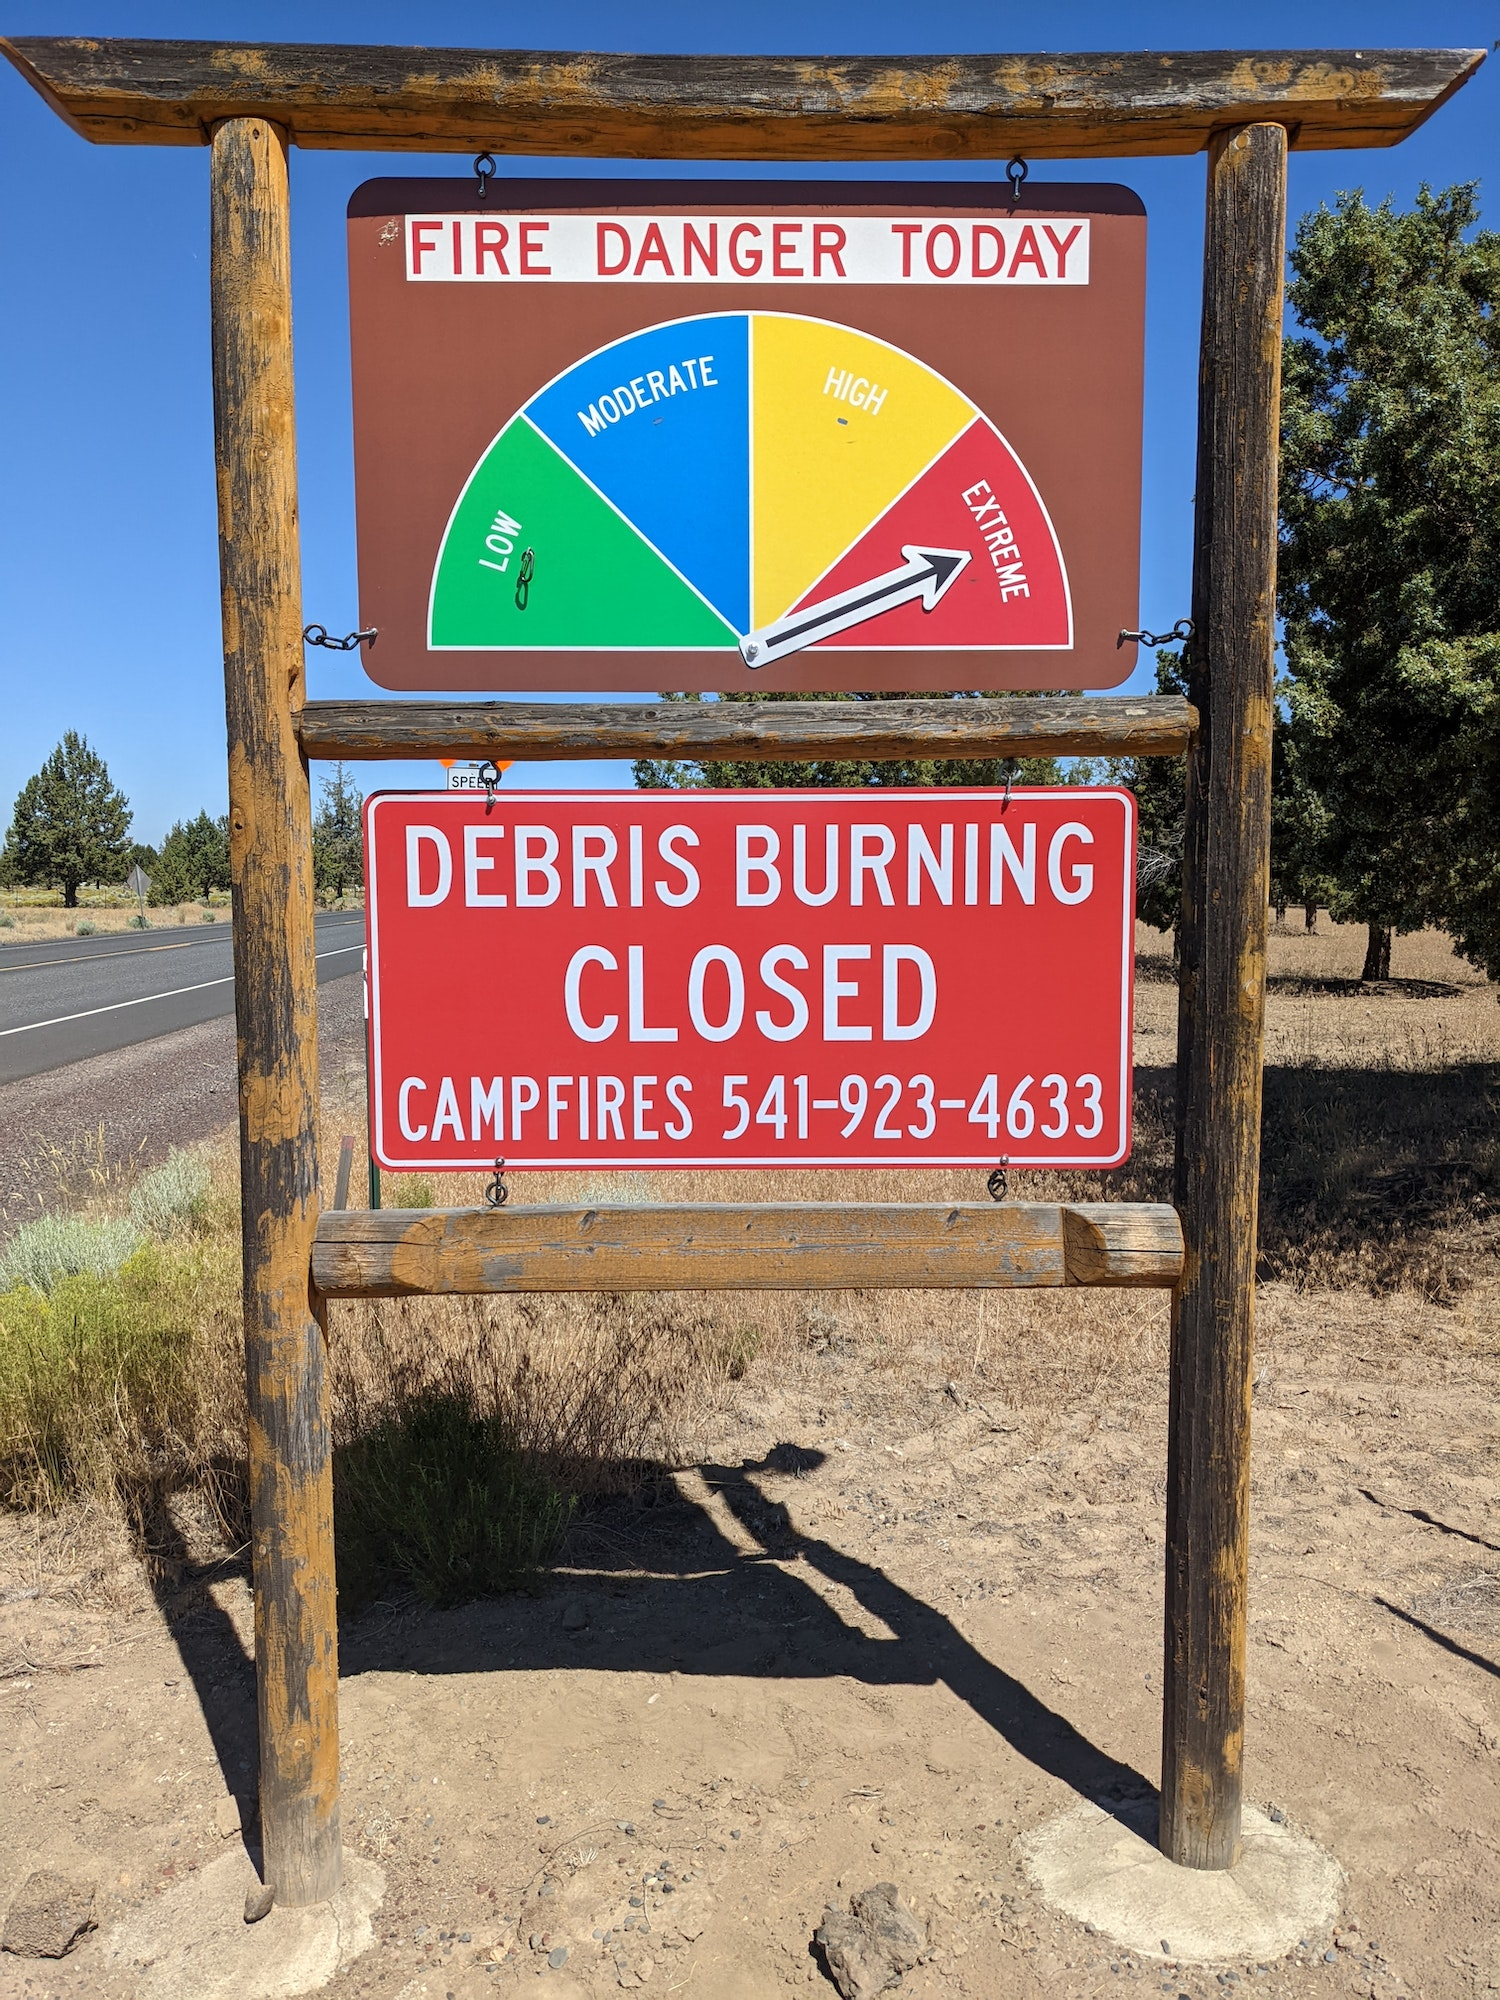

Every fire season had it's regular calling cards: the road signs, thier silent warnings, and the dried grass at thier bases. We would start looking earlier though, aiming our eyes at the Cascade Mountains and waiting for the snow to fall. To melt. 

Now, global climate change is driving shifts in where and how much precipitation falls. While floods submerge Pakistan () , droughts imperil American agriculture. It feels like we are waiting again, many of us asking, "How will these changing climate patterns affect us? Our homes?" This question might seem dramatic, but its pragmatic cousin is asked more frequently: "What's the forecast?" 

A forecast is a model that is based on the prior results that helps us anticipate and plan for future conditions. We can model climate, the repetitive global patterns that produce regular cycles of weather, the conditions at any one place and time. Climate models are produced directly from weather records; if the weather conditions being predicted have changed from conditions used to build the model, the climate model will not be able to accurately predict the weather.

Since moving to the Boston area in 2018, I feel like I have watched the weather- and thus the climate- change. It feels much hotter and it seems like there are fewer thunderstorms in the summer. Similarly to my childhood, it feels like there is less snow every year, and I'm starting to see drought maps and burn warnings appear. The consequences are commonsense: indoor and outdoor water usage increases as resevoir and groundwater levels drop, vegetation dries out, and fire risks increase. 

As an earth scientist, I'm deeply curious about how terrestrial conditions impact organisms, including those pesky humans. As a Bostonian, I just want to know if I can expect a wet winter in 2022. My goal in this analysis is not to create anything approaching a full climate model but to 
- perform basic statistical analyses on multi-decadal precipiation data from Massachussets
- maybe: apply a principal components analysis to see where variation exists in dataset 
- apply a clustering algorithm to determine if regional patterns appear
- apply --machine learning methods-- to predict precipitation type and amount across the state


# Data Collection and Cleaning

In [48]:
import copy
import math
import numpy as np
import pandas as pd


I used the 'Precipitation Database Data 2019' dataset from the Massachusetts Department of Conservation & Recreation's Office of Water Resources (https://www.mass.gov/info-details/precipitation-data). This dataset is comprised of observed monthly preciptiation totals for weather stations around Massachusetts. While I am interested in snowfall, it can be difficult to compare to rainfall since snow volume and water content are less constrained by eachother (e.g., you can have drier 'powder' or the type of wet snow that packs well into a snowball). This dataset handles this issue by requiring snow precipitation be melted and it's equivalent in inches of water is measured. I can directly compare both types of precipitation.    

Note: This dataset reports in imperial units (inches). I am refraining from converting to metric immediately to prevent rounding errors later.    

First, I'll open the file and print a sample of it's contents to make sure it looks like it loaded correctly.    


In [41]:
# Load dataset
precip_data = pd.read_excel(r'C:\Users\15414\Documents\GitHub\MA Precip\Precipitation Database 10.19.xls')
precip_data.head(2)

,STATION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,CITY,Region Composite Station,Region,Basin Name
0,AMH307,1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amherst,Yes,Connecticut River,CONNECTICUT
1,AMH307,1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amherst,Yes,Connecticut River,CONNECTICUT


In [42]:
# Print all unique rows in the region data columns.
region_data = precip_data[['Region', 'Basin Name']]
unique_regions = region_data.drop_duplicates()
unique_regions = unique_regions.sort_values(by=['Region', 'Basin Name'])
unique_regions

,Region,Basin Name
611,Cape Cod and Islands,CAPE COD
2838,Cape Cod and Islands,ISLANDS
2763,Central,BLACKSTONE
525,Central,CHICOPEE
1743,Central,FRENCH
298,Central,MILLERS
224,Central,NASHUA
10216,Central,QUINEBAUG
717,Connecticut River,CHICOPEE
0,Connecticut River,CONNECTICUT


There are several regions and basins that are not defined (NaN). Why do some places not have this data? There are 9 stations of 188 unique stations containing a spatial NaN value. The records with no region could potentially be assigned to regions, but towns cannot be assigned to drainage basins without expert determination. I think the regions correspond to the MA drought regions (https://www.mass.gov/service-details/drought-regions), but since I cannot confirm this, I solve the issue entirely by removing the station records where Basin Name and Region are NaN.

In [43]:
# Select all unique rows in the station data columns.
station_data = precip_data[['Region', 'Basin Name', 'CITY', 'STATION']]
unique_stations = station_data.drop_duplicates()
unique_stations = unique_stations.sort_values(by=['Region', 'Basin Name'])
print(len(unique_stations))


188


In [44]:
# Print stations with NaN data.
print(unique_stations.loc[(unique_stations['Region'].isna() | unique_stations['Basin Name'].isna())])


          Region Basin Name              CITY STATION
7917   Northeast        NaN            Newton  NEW712
8287   Northeast        NaN     North Andover  NOR550
8606   Northeast        NaN           Peabody  PEA611
11654    Western        NaN         West Otis  WES101
1111         NaN    MILLERS   South Royalston  BIRCOE
2784         NaN  QUINEBAUG          Fiskdale  EBRCOE
1233         NaN  WESTFIELD         Blandford  BORNWS
3179         NaN        NaN       Fitzwilliam  FIT401
8295         NaN        NaN  North  Attleboro  NOR800


In [45]:
# Remove problematic locality records
precip_data = precip_data.loc[(precip_data['Region'].notna() & 
                               precip_data['Basin Name'].notna())]

# Check if values were removed. Output should be 188 - 9.
station_data = precip_data[['Region', 'Basin Name', 'CITY', 'STATION']]
unique_stations = station_data.drop_duplicates()
unique_stations = unique_stations.sort_values(by=['Region', 'Basin Name'])
print(len(unique_stations))
      

179


This dataset is also better split into two tables: a table for precipitation data and a separate table for location data. Each relates to the other by the station. Since there is already a unique stations table, I will remove that data from the precipitation table.

In [46]:
precip_data = precip_data.iloc[:,:-4]
print(len(precip_data))
precip_data.head(5)

12701


,STATION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,AMH307,1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AMH307,1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AMH307,2000,3.04,3.39,3.96,4.25,4.52,9.03,5.99,5.33,3.27,2.63,2.25,4.41
3,AMH307,2001,NaN,NaN,NaN,5.35,3.65,6.15,3.44,0.93,3.30,0.91,0.87,5.96
4,AMH307,2002,5.93,NaN,4.36,3.62,4.56,5.82,2.35,2.56,4.44,6.76,5.20,6.38


There are several years where every month has an NaN value. Since there is no data to anaylze, I want to remove these years.

In [105]:
precip_test = copy.deepcopy(precip_data)
print(id(precip_test), id(precip_data))

precip_data.head(5)

2709506980104 2709497365784


,STATION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,AMH307,1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AMH307,1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AMH307,2000,3.04,3.39,3.96,4.25,4.52,9.03,5.99,5.33,3.27,2.63,2.25,4.41
3,AMH307,2001,NaN,NaN,NaN,5.35,3.65,6.15,3.44,0.93,3.30,0.91,0.87,5.96
4,AMH307,2002,5.93,NaN,4.36,3.62,4.56,5.82,2.35,2.56,4.44,6.76,5.20,6.38


In [106]:
table_length = len(precip_data)
indexes_to_drop = []

for row in range(0,table_length):
    no_data_months = 0
    for column in range(2,14):
        if pd.isna(precip_data.iloc[row,column]):
            no_data_months = no_data_months + 1
    if no_data_months == 12:
        indexes_to_drop.append(row)

precip_test.drop(indexes_to_drop, inplace=True)
precip_test.head(5)

,STATION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
2,AMH307,2000,3.04,3.39,3.96,4.25,4.52,9.03,5.99,5.33,3.27,2.63,2.25,4.41
3,AMH307,2001,NaN,NaN,NaN,5.35,3.65,6.15,3.44,0.93,3.30,0.91,0.87,5.96
4,AMH307,2002,5.93,NaN,4.36,3.62,4.56,5.82,2.35,2.56,4.44,6.76,5.20,6.38
5,AMH307,2003,3.02,8.18,4.89,3.78,4.86,6.16,2.89,6.82,10.35,5.42,3.65,4.92
6,AMH307,2004,1.50,1.60,2.15,6.80,4.87,2.04,3.74,3.41,9.89,2.50,3.64,3.64


The interesting parts of this dataset are multi-dimensional, meaning that the data can be represented along more than two axes. Precipitation data maps to a specific month in a one-to-one fashion and to a specific year for a specific station in a one-to-many-to-many fashion. Currently, the data is flattened into a two-dimensional table, resulting in duplicates across the year and station columns.

First I will need to convert the precipitation data from twelve columns to one list. Then I will create lists with the appropriate month, year, and station values.

In [116]:
# Create the precipitation and month list
precips_flat = precip_data.iloc[:,2:].unstack() # Unstack/flatten precip data only.
precips_flat = precips_flat.values.tolist()

months_flat = len(precip_data)*[1,2,3,4,5,6,7,8,9,10,11,12]


In [123]:
# Add the station and year twelve times for every row to the appropriate list to convert to months.
stations_flat = []
years_flat = []

for row in range(0, table_length):
    station_name = [precip_data.iloc[row,0]] # Select station name as list element.
    dozen_stations = station_name * 12
    stations_flat = stations_flat + (dozen_stations)
    
    years = [precip_data.iloc[row,1]]
    dozen_years = years * 12
    years_flat = years_flat + (dozen_years)


In [124]:
# Convert lists to a dictionary to a completely flattened dataframe.
data = {'Station': stations_flat,
        'Year': years_flat,
        'Month': months_flat,
        'Precipitation': precips_flat}

precip_flat = pd.DataFrame(data)
precip_flat.head(5)

,Station,Year,Month,Precipitation
0,AMH307,1997,1,NaN
1,AMH307,1997,2,NaN
2,AMH307,1997,3,3.04
3,AMH307,1997,4,NaN
4,AMH307,1997,5,5.93


In [126]:
# Convert flattened data to multiIndex object.
precip_multi = flat_precip_data.set_index(['Station', 'Year', 'Month', 'Precipitation'])
precip_multi.head(15)


Empty DataFrame
Columns: []
Index: [(AMH307, 1997, 1, nan), (AMH307, 1997, 2, nan), (AMH307, 1997, 3, 3.04), (AMH307, 1997, 4, nan), (AMH307, 1997, 5, 5.93), (AMH307, 1997, 6, 3.02), (AMH307, 1997, 7, 1.5), (AMH307, 1997, 8, 4.45), (AMH307, 1997, 9, 5.86), (AMH307, 1997, 10, 5.86), (AMH307, 1997, 11, 1.58), (AMH307, 1997, 12, 2.47), (AMH307, 1998, 1, 2.4), (AMH307, 1998, 2, 2.79), (AMH307, 1998, 3, 2.98)]

# Exploratory Analyses

## Basic Statistics and Visualization 
- summary statistics and visualization of each variable
- 

## Clustering

Clustering algorithms find 

In [ ]:
# Data Visualization
### Could be cool to have a graphic where clusters change colors depending on average precip value

# Predictive Analyses

How can we apply this data to project future precipitation levels?

# Summary

# Notes

### Data to follow up on
https://www.mass.gov/doc/framework-november-2012/download